# Проект: Определение возраста покупателей.

# Описание проекта.

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# План работы:

 - 1.Проведите исследовательский анализ набора фотографий.
 - 2.Подготовьте данные к обучению.
 - 3.Обучите нейронную сеть и рассчитайте её качество:
     - Постройте и обучите свёрточную нейронную сеть на датасете с фотографиями людей. Добейтесь значения MAE на тестовой выборке не больше 8.
     - Функцию загрузки тестовой выборки load_test(path) напишите самостоятельно. Вместе со старыми функциями в коде должны быть:
         - load_train(path);
         - load_test(path);
         - create_model(input_shape);
         - train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps);

# Описание данных:

**Данные для обучения хранятся в папке "path":**

 - **csv-файл "labels.csv" с двумя колонками:**
 
   - **file_name** - имя файла(изображения);
   - **real_age** - возраст человека на изображении;
   
   
  
 - **папка с изображениями "/final_files".**

# Рекомендации к выполнению проекта:

 - Функцией потерь не обязательно должна быть MAE. Зачастую нейронные сети с функцией потерь MSE обучаются быстрее.
 - Качество на валидационной выборке улучшается, но модель при этом переобучается всё сильнее? Не спешите менять модель. Обычно нейронные сети с большим числом слоёв сильно переобучаются.
 - Проверьте, что методы **load_train(path)** и **load_test(path)** корректно работают с данными. В папке **path** содержится csv-файл **labels.csv** с двумя колонками **file_name** и **real_age** и папка с изображениями **/final_files.** Прочитайте данные из csv-файла **labels.csv** в датафрейм, который будет одним из параметров метода **ImageDataGenerator —flow_from_dataframe(dataframe, directory, ...)**.

## Исследовательский анализ данных

In [2]:
# Загрузим нужные библиотеки и методы
import numpy as np
import pandas as pd
 
from PIL import Image
import matplotlib.pyplot as plt
 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [3]:
# Сохраним данные в переменные
data_0 = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data_0,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
# Выведем размер датасета на экран
data_0.shape

(7591, 2)

In [5]:
# Объявим функцию для построения графика
def distribution(data, fx):
    data[fx].plot(kind='box', grid=True)
    plt.show()

    display(data[fx].describe())

    data[fx].plot(kind='hist', grid=True, bins=30)
    plt.title(f'Распределение признака {fx}')
    plt.xlabel(f'Возраст')
    plt.ylabel(f'Величина значений {fx}')

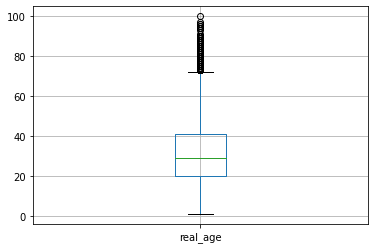

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

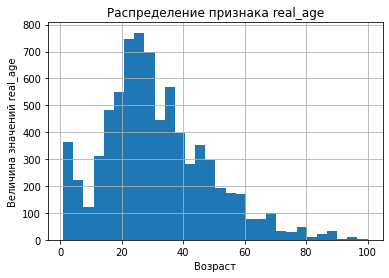

In [6]:
# Построим график распределения возрастов
distribution(data_0, 'real_age')

**Вывод:** Из "ящика с усами" видно, что в данных есть выбросы, но фактически эти данные не являются выбросами, а представляют собой диапазон возрастов, который нужно учитывать в задаче. Медианное значение real_age равно 29.0. Распределение значений имеет вид близкий к нормальному.

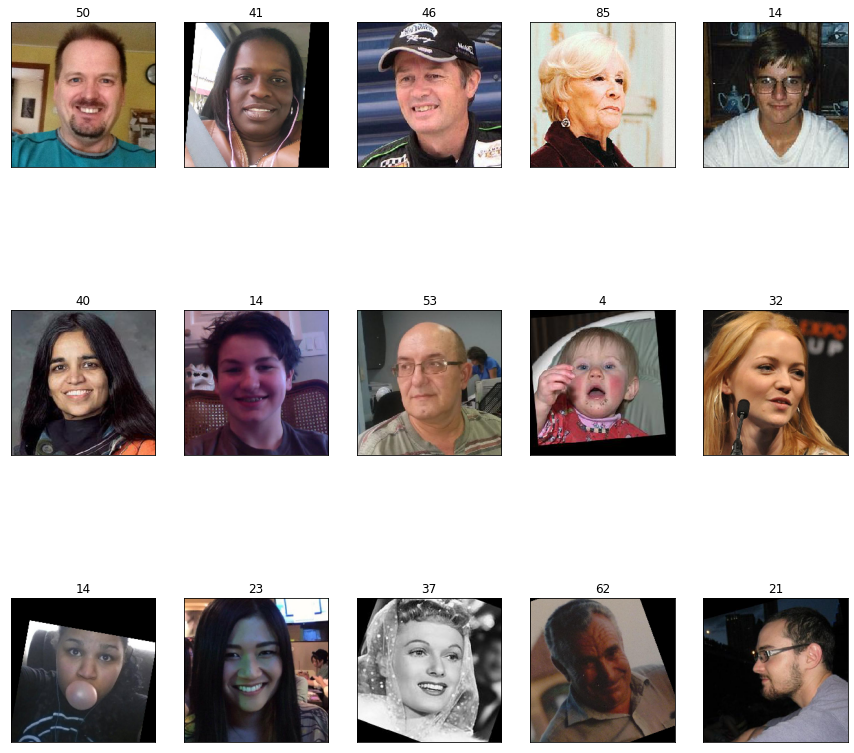

In [7]:
# Выведем на экран 15 изображений из датасета
x, y = next(train_gen_flow)
fig = plt.figure(figsize=(15, 15))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(x[i])
    plt.title(y[i])
    plt.xticks([])
    plt.yticks([])

**Вывод:** 
- Из графика распределения возраста в выборке видно, что распределение не равномерно. Людей некоторого возраста меньше, чем остальных, это может сказаться на обучении модели.
- Дополнительная обработка фотографий не требуется.
- Недостаточное колличество фотографий детей около 9 - 10 лет и пожилых людей старше 60 лет так же может сказаться на качестве обучения модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1/255)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+"/final_files/",
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0002)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, 
                train_data, 
                test_data, 
                batch_size=None, 
                epochs=5,
                steps_per_epoch=None, 
                validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

2025-02-23 16:15:35.426333: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2025-02-23 16:15:35.428343: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2025-02-23 16:15:36.543939: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-02-23 16:15:36.551134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-02-23 16:15:36.551210: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-02-23 16:15:36.551250: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-02-23 16:15:36.553476: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-02-23 16:15:36.553896: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-02-23 16:15:36.556302: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-02-23 16:15:36.557632: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-02-23 16:15:36.557693: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-02-23 16:15:36.560785: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2025-02-23 16:15:36.774476: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2025-02-23 16:15:36.782535: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2025-02-23 16:15:36.783227: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4d7f140 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-02-23 16:15:36.783259: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-02-23 16:15:36.930907: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6092720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-23 16:15:36.930980: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2025-02-23 16:15:36.932790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2025-02-23 16:15:36.932861: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-02-23 16:15:36.932890: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-02-23 16:15:36.932935: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2025-02-23 16:15:36.932968: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2025-02-23 16:15:36.933000: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2025-02-23 16:15:36.933029: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2025-02-23 16:15:36.933050: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2025-02-23 16:15:36.936292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2025-02-23 16:15:36.936363: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-02-23 16:15:37.414134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2025-02-23 16:15:37.414203: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2025-02-23 16:15:37.414219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2025-02-23 16:15:37.417609: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-02-23 16:15:37.417688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
  114688/94765736 [..............................] - ETA: 42s
  565248/94765736 [..............................] - ETA: 16s
 2162688/94765736 [..............................] - ETA: 6s 
 6389760/94765736 [=>............................] - ETA: 2s
10493952/94765736 [==>...........................] - ETA: 2s
16728064/94765736 [====>.........................] - ETA: 1s
20979712/94765736 [=====>........................] - ETA: 1s
27000832/94765736 [=======>......................] - ETA: 1s
31465472/94765736 [========>.....................] - ETA: 1s
37617664/94765736 [==========>...................] - ETA: 0s
41951232/94765736 [============>.................] - ETA: 0s
47857664/94765736 [==============>...............] - ETA: 0s
52436992/94765736 [===============>..............] - ETA: 0s
58376192/94765736 [=================>............] - ETA: 0s
62922752/94765736 [==================>...........] - ETA: 0s
69140480/94765736 [====================>.........] - ETA: 0s
73408512/94765736 [======================>.......] - ETA: 0s
78413824/94765736 [=======================>......] - ETA: 0s
82518016/94765736 [=========================>....] - ETA: 0s
85671936/94765736 [==========================>...] - ETA: 0s
91373568/94765736 [===========================>..] - ETA: 0s
94380032/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/5
2025-02-23 16:15:53.884237: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-02-23 16:15:54.293365: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 59s - loss: 204.7525 - mae: 10.3393 - val_loss: 884.0473 - val_mae: 24.8794
Epoch 2/5
178/178 - 48s - loss: 82.0612 - mae: 6.8760 - val_loss: 533.8959 - val_mae: 17.9083
Epoch 3/5
178/178 - 47s - loss: 55.5316 - mae: 5.6770 - val_loss: 400.1898 - val_mae: 14.9315
Epoch 4/5
178/178 - 48s - loss: 43.0205 - mae: 5.0022 - val_loss: 117.0552 - val_mae: 8.1847
Epoch 5/5
178/178 - 49s - loss: 33.8048 - mae: 4.4089 - val_loss: 91.4112 - val_mae: 7.3169
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 91.4112 - mae: 7.3169



```

## Анализ обученной модели

**Сделаем вывод по исследовательскому анализу данных:** 

Из "ящика с усами" видно, что в данных есть выбросы, но фактически эти данные не являются выбросами, а представляют собой диапазон возрастов, который нужно учитывать в задаче. Медианное значение real_age равно 29.0. Распределение значений имеет вид близкий к нормальному.

- Из графика распределения возраста в выборке видно, что распределение не равномерно. Людей некоторого возраста меньше, чем остальных, это может сказаться на обучении модели.
- Дополнительная обработка фотографий не требуется.
- Недостаточное колличество фотографий детей около 9 - 10 лет и пожилых людей старше 60 лет так же может сказаться на качестве обучения модели.

**Сделаем общий вывод по проделанному исследованию:**

В качестве гиперпараметров мы использовали batch_size=32, Adam(lr=0.0002), metrics=['mae']. Мы использовали в качестве функции потерь MSE, так как с ней нейронные сети обучаются быстрее. Количество эпох мы подобрали равным 5, т.к. большее число приводило к переобучению. Для улучшения результатов предсказания имеет смысл выровнять количество фотографий людей по возрастам.

Цель обучения нейронной сети достигнута. С помощью подбора гиперпараметров мы добились  высокой точности в 7.3169 на метрике MAE, что меньше заданного поргового значения равного 8.